In [1]:
import sys, os, time, shutil, random
from pathlib import Path
_cwd = os.getcwd()
os.chdir(Path(_cwd)/'..')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload
%autoreload 2
# %pdb
import omnifig as fig
import numpy as np
np.set_printoptions(linewidth=120)
import pickle
from tabulate import tabulate
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
# import torchvision.models
from torch.utils.data import Dataset, DataLoader, TensorDataset

%matplotlib notebook
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.cm
from matplotlib import animation
import matplotlib as mpl
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
# mpl.rc('image', cmap='gray')
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize

from adjustText import adjust_text

fig.initialize()

import foundation as fd
from foundation import models
from foundation import util
from foundation.op.analysis import Run_Manager
from foundation.data import Intervention_Sampler

from sklearn.decomposition import PCA
import sklearn.datasets

from sae_src import sample_full_interventions, response_mat, factor_reponses

# import gpumap
from c3linearize import linearize, class_graph

In [2]:
save_figure_kwargs = dict(
    root = r'C:\Users\anwan\OneDrive\Khan\research\learn_rep\figures\icml',
    exts = ['png', 'pdf'],
)

def preset_figure_info(info):
    plt.rc('font', size=info.small_font_size)          # controls default text sizes
    plt.rc('axes', titlesize=info.small_font_size)     # fontsize of the axes title
    plt.rc('axes', labelsize=info.medium_font_size)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=info.small_font_size)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=info.small_font_size)    # fontsize of the tick labels
    plt.rc('legend', fontsize=info.small_font_size)    # legend fontsize
    plt.rc('figure', titlesize=info.large_font_size)  # fontsize of the figure title
    

info = util.adict()

info.fsize = (9,6)

info.cut = 'eval'
info.cut = 'final'

info.device = 'cuda:1'

info.results_name = 'final'
# info.results_name = 'results'

info.small_font_size = 14
info.medium_font_size = 16
info.large_font_size = 18

info.colors = {n:f'C{n}' for n in range(10)}
info.group_names = {1:'Baseline', 0: 'Structural', 3:'Ladder', 2:'Adaptive', }

preset_figure_info(info)
print(info)

t{fsize, cut, device, results_name, small_font_size, medium_font_size, large_font_size, colors, group_names}


In [3]:
raw = '''AE	celeba_ae0_e-c16_d-c16_mish_210125-132401	3ds_ae0_e-c12_d-c12_mish_210125-050038	toy_ae_e-c12_d-c12_mish_210125-222234	sim_ae_e-c12_d-c12_mish_210126-035850	real_ae_e-c12_d-c12_mish_210126-035928
VAE1	celeba_vae1_e-c16_d-c16_mish_210125-132401	3ds_vae1_e-c12_d-c12_mish_210125-140254	toy_vae1_e-c12_d-c12_mish_210126-122537	sim_vae1_e-c12_d-c12_mish_210126-123641	real_vae1_e-c12_d-c12_mish_210126-123340
VAE2		3ds_vae2_e-c12_d-c12_mish_210125-140255	toy_vae2_e-c12_d-c12_mish_210126-122537	sim_vae2_e-c12_d-c12_mish_210126-123642	real_vae2_e-c12_d-c12_mish_210126-123340
VAE4		3ds_vae4_e-c12_d-c12_mish_210125-140302	toy_vae4_e-c12_d-c12_mish_210127-231812	sim_vae4_e-c12_d-c12_mish_210127-231257	real_vae4_e-c12_d-c12_mish_210127-231852
VAE8		3ds_vae8_e-c12_d-c12_mish_210125-140550	toy_vae8_e-c12_d-c12_mish_210127-231816	sim_vae8_e-c12_d-c12_mish_210127-231257	real_vae8_e-c12_d-c12_mish_210127-231853
WAE10		3ds_wae10_e-c12_d-c12_mish_210125-140253	toy_wae10_e-c12_d-c12_mish_210126-122537	sim_wae10_e-c12_d-c12_mish_210126-123641	real_wae10_e-c12_d-c12_mish_210126-123340
WAE100		3ds_wae100_e-c12_d-c12_mish_210125-221143	toy_wae100_e-c12_d-c12_mish_210126-122537	sim_wae100_e-c12_d-c12_mish_210126-123641	real_wae100_e-c12_d-c12_mish_210126-123340
WAE1000		3ds_wae1000_e-c12_d-c12_mish_210125-221142	toy_wae1000_e-c12_d-c12_mish_210126-122537	sim_wae1000_e-c12_d-c12_mish_210126-123641	real_wae1000_e-c12_d-c12_mish_210126-123339
AE S2		3ds_ae_e-c12_d-s2_mish_210131-150237	toy_ae_e-c12_d-s2_mish_210127-231820	sim_ae_e-c12_d-s2_mish_210127-231304	real_ae_e-c12_d-s2_mish_210127-231829
AE S2 nosplit		3ds_ae_e-c12_d-s2_nosplit-mish_210131-150234	toy_ae_e-c12_d-s2_nosplit-mish_210131-150234	sim_ae_e-c12_d-s2_nosplit-mish_210127-231312	real_ae_e-c12_d-s2_nosplit-mish_210131-150234
AE S3		3ds_ae_e-c12_d-s3_mish_210201-021841	toy_ae_e-c12_d-s3_mish_210127-231823	sim_ae_e-c12_d-s3_mish_210127-231307	real_ae_e-c12_d-s3_mish_210127-231829
AE S3 nosplit		3ds_ae_e-c12_d-s3_nosplit-mish_210131-150234	toy_ae_e-c12_d-s3_nosplit-mish_210131-150236	sim_ae_e-c12_d-s3_nosplit-mish_210127-231312	real_ae_e-c12_d-s3_nosplit-mish_210131-150234
AE S4		3ds_ae0_e-c12_d-s4_mish_210125-140253	toy_ae_e-c12_d-s4_mish_210126-122536	sim_ae_e-c12_d-s4_mish_210127-231308	real_ae_e-c12_d-s4_mish_210126-123339
AE S4 nosplit		3ds_ae_e-c12_d-s4_nosplit-mish_210131-150234	toy_ae_e-c12_d-s4_nosplit-mish_210131-150235	sim_ae_e-c12_d-s4_nosplit-mish_210127-231315	real_ae_e-c12_d-s4_nosplit-mish_210131-150234
AE S6		3ds_ae0_e-c12_d-s6_mish_210125-140253	toy_ae_e-c12_d-s6_mish_210126-122536	sim_ae_e-c12_d-s6_mish_210127-231308	real_ae_e-c12_d-s6_mish_210126-123339
AE S6 nosplit		3ds_ae_e-c12_d-s6_nosplit-mish_210131-150234	toy_ae_e-c12_d-s6_nosplit-mish_210131-150236	sim_ae_e-c12_d-s6_nosplit-mish_210127-231313	real_ae_e-c12_d-s6_nosplit-mish_210131-150236
AE S12	celeba_ae0_e-c16_d-s16_mish_210125-132401	3ds_ae0_e-c12_d-s12_mish_210125-050335	toy_ae_e-c12_d-s12_mish_210125-222233	sim_ae_e-c12_d-s12_mish_210126-035851	real_ae_e-c12_d-s12_mish-seed5_210131-150235
AE S12 nosplit	celeba_ae0_e-c16_d-s16_nosplit-mish_210125-132401	3ds_ae_e-c12_d-s12_nosplit-mish_210131-150236	toy_ae_e-c12_d-s12_nosplit-mish_210131-150234	sim_ae_e-c12_d-s12_nosplit-mish_210127-231314	real_ae_e-c12_d-s12_nosplit-mish_210127-231851
VAE1 L2		3ds_vae1_e-l2_d-l2_mish_210131-150235	toy_vae1_e-l2_d-l2_mish_210131-150234	sim_vae1_e-l2_d-l2_mish_210131-150238	real_vae1_e-l2_d-l2_mish_210131-150240
VAE1 L3		3ds_vae1_e-l3_d-l3_mish_210131-150235	toy_vae1_e-l3_d-l3_mish_210131-150234	sim_vae1_e-l3_d-l3_mish_210131-150236	real_vae1_e-l3_d-l3_mish_210131-150236
VAE1 L4		3ds_vae1_e-l4_d-l4_mish_210125-134914	toy_vae1_e-l4_d-l4_mish_210131-150235	sim_vae1_e-l4_d-l4_mish_210127-231449	real_vae1_e-l4_d-l4_mish_210131-150236
VAE1 L6		3ds_vae1_e-l6_d-l6_mish_210125-140021	toy_vae1_e-l6_d-l6_mish_210131-150235	sim_vae1_e-l6_d-l6_mish_210127-231447	real_vae1_e-l6_d-l6_mish_210131-150236
VAE1 L12	celeba_vae1_e-l16_d-l16_mish_210125-132401	3ds_vae1_e-l12_d-l12_mish_210125-140249	toy_vae1_e-l12_d-l12_mish_210131-150237	sim_vae1_e-l12_d-l12_mish_210127-231450	real_vae1_e-l12_d-l12_mish_210127-231847'''

model_tbl = [row.split('\t') for row in raw.split('\n')]
headers = ['Name', 'CelebA', '3D-Shapes', 'MPI3D Toy', 'MPI3D Sim', 'MPI3D Real']
dataset_names = headers[1:]
all_model_names = {ds:{} for ds in dataset_names}
for title, *names in model_tbl:
    for path, ds in zip(names, dataset_names):
        if path is not None and len(path):
            all_model_names[ds][title] = path
print(tabulate(model_tbl, headers=headers))
len(model_tbl)

Name            CelebA                                             3D-Shapes                                      MPI3D Toy                                      MPI3D Sim                                      MPI3D Real
--------------  -------------------------------------------------  ---------------------------------------------  ---------------------------------------------  ---------------------------------------------  ----------------------------------------------
AE              celeba_ae0_e-c16_d-c16_mish_210125-132401          3ds_ae0_e-c12_d-c12_mish_210125-050038         toy_ae_e-c12_d-c12_mish_210125-222234          sim_ae_e-c12_d-c12_mish_210126-035850          real_ae_e-c12_d-c12_mish_210126-035928
VAE1            celeba_vae1_e-c16_d-c16_mish_210125-132401         3ds_vae1_e-c12_d-c12_mish_210125-140254        toy_vae1_e-c12_d-c12_mish_210126-122537        sim_vae1_e-c12_d-c12_mish_210126-123641        real_vae1_e-c12_d-c12_mish_210126-123340
VAE2                          

23

In [4]:
root = Path(r'C:\Users\anwan\Documents\workspace\sae\final')
device = 'cuda'

In [5]:
base_codes = {'AE':'AE', 'VAE1':'VAE', 'VAE2':'VAE2', 'VAE4':'VAE4', 'VAE8':'VAE8', 'WAE10':'WAE1', 'WAE100':'WAE2', 'WAE1000':'WAE3', 
               'AE S2':'S2', 'AE S3':'S3', 'AE S4':'S4', 'AE S6':'S6', 'AE S12':'S12', 
               'VAE1 L2':'L2', 'VAE1 L3':'L3', 'VAE1 L4':'L4', 'VAE1 L6':'L6', 'VAE1 L12':'L12', 
               'AE S2 nosplit':'S2n', 'AE S3 nosplit':'S3n', 'AE S4 nosplit':'S4n', 'AE S6 nosplit':'S6n', 'AE S12 nosplit':'S12n', 
              }
base_titles = {'AE':'AE', 'VAE1':'VAE', 'VAE2':'VAE2', 'VAE4':'VAE4', 'VAE8':'VAE8', 'WAE10':'WAE1', 'WAE100':'WAE2', 'WAE1000':'WAE3', 
               'AE S2':'SAE-2', 'AE S3':'SAE-3', 'AE S4':'SAE-4', 'AE S6':'SAE-6', 'AE S12':'SAE-12', 
               'VAE1 L2':'VLAE-2', 'VAE1 L3':'VLAE-3', 'VAE1 L4':'VLAE-4', 'VAE1 L6':'VLAE-6', 'VAE1 L12':'VLAE-12', 
               'AE S2 nosplit':'AdaAE-2', 'AE S3 nosplit':'AdaAE-3', 'AE S4 nosplit':'AdaAE-4', 'AE S6 nosplit':'AdaAE-6', 'AE S12 nosplit':'AdaAE-12', 
              }
title_order_base = ['AE S12', 'AE S6', 'AE S4', 'AE S3', 'AE S2', 
               'VAE1 L12', 'VAE1 L6', 'VAE1 L4', 'VAE1 L3', 'VAE1 L2',
               'AE S12 nosplit', 'AE S6 nosplit', 'AE S4 nosplit', 'AE S3 nosplit', 'AE S2 nosplit',
               'AE', 'VAE1', 'VAE2', 'VAE4', 'VAE8', 'WAE10', 'WAE100', 'WAE1000',
              ]

mytitles = {}

In [6]:
ds = 'CelebA'
dscode = 'celeb'

mytitles = {k:v.replace('12', '16') for k,v in base_titles.items()}
mytitles['VAE1 L12'] = None

In [6]:
ds = '3D-Shapes'
dscode = '3ds'

mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None, }

In [56]:
ds = 'MPI3D Sim'
dscode = 'sim'

mytitles = {'AE S6 nosplit': None, 'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None,}

In [154]:
ds = 'MPI3D Toy'
dscode = 'toy'


mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None, }

In [55]:
ds = 'MPI3D Real'
dscode = 'real'


mytitles = {'VAE2':r'$\beta$VAE', 'VAE4':None, 'VAE8':None, 'WAE10':'WAE', 'WAE100':None, 'WAE1000':None, }

In [7]:
groups_idx = {'AE':1, 'VAE1':1, 'VAE2':1, 'VAE4':1, 'VAE8':1, 'WAE10':1, 'WAE100':1, 'WAE1000':1, 
          'AE S2':0, 'AE S3':0, 'AE S4':0, 'AE S6':0, 'AE S12':0, 
          'VAE1 L2':3, 'VAE1 L3':3, 'VAE1 L4':3, 'VAE1 L6':3, 'VAE1 L12':3, 
          'AE S2 nosplit':2, 'AE S3 nosplit':2, 'AE S4 nosplit':2, 'AE S6 nosplit':2, 'AE S12 nosplit':2}



titles = base_titles.copy()
titles.update(mytitles)

info.title = ds
model_names = {k:v for k,v in all_model_names[ds].items() if titles[k] is not None}
len(model_names), model_names.keys()

(19,
 dict_keys(['AE', 'VAE1', 'VAE2', 'WAE10', 'AE S2', 'AE S2 nosplit', 'AE S3', 'AE S3 nosplit', 'AE S4', 'AE S4 nosplit', 'AE S6', 'AE S6 nosplit', 'AE S12', 'AE S12 nosplit', 'VAE1 L2', 'VAE1 L3', 'VAE1 L4', 'VAE1 L6', 'VAE1 L12']))

In [8]:
runs = Run_Manager(model_names, root=root, override={'device':device}, pbar=tqdm)
run_idents = {r.ident:r for r in runs}
title_order = [t for t in title_order_base if t in run_idents]

  0%|          | 0/19 [00:00<?, ?it/s]

Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\final\3ds_ae0_e-c12_d-c12_mish_210125-050038\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\final\3ds_vae1_e-c12_d-c12_mish_210125-140254\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\final\3ds_vae2_e-c12_d-c12_mish_210125-140255\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\final\3ds_wae10_e-c12_d-c12_mish_210125-140253\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\final\3ds_ae_e-c12_d-s2_mish_210131-150237\config.yaml


Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\final\3ds_ae_e-c12_d-s2_nosplit-mish_210131-150234\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\final\3ds_ae_e-c12_d-s3_mish_210201-021841\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\final\3ds_ae_e-c12_d-s3_nosplit-mish_210131-150234\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\final\3ds_ae0_e-c12_d-s4_mish_210125-140253\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\final\3ds_ae_e-c12_d-s4_nosplit-mish_210131-150234\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\final\3ds_ae0_e-c12_d-s6_mish_210125-140253\config.yaml


Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\final\3ds_ae_e-c12_d-s6_nosplit-mish_210131-150234\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\final\3ds_ae0_e-c12_d-s12_mish_210125-050335\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\final\3ds_ae_e-c12_d-s12_nosplit-mish_210131-150236\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\final\3ds_vae1_e-l2_d-l2_mish_210131-150235\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\final\3ds_vae1_e-l3_d-l3_mish_210131-150235\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\final\3ds_vae1_e-l4_d-l4_mish_210125-134914\config.yaml


Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\final\3ds_vae1_e-l6_d-l6_mish_210125-140021\config.yaml
Loading Config (for run): C:\Users\anwan\Documents\workspace\sae\final\3ds_vae1_e-l12_d-l12_mish_210125-140249\config.yaml


In [9]:
runs.map(lambda run: run.get_records())
runs.load_results('metrics', safe=True, load_kwargs={'device':device});
runs.load_results('final-hyb', safe=True, load_kwargs={'device':device});
runs.load_results(info.cut, load_kwargs={'device':device});

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

3ds_ae0_e-c12_d-c12_mish_210125-050038 failed
3ds_vae1_e-c12_d-c12_mish_210125-140254 failed
3ds_vae2_e-c12_d-c12_mish_210125-140255 failed
3ds_wae10_e-c12_d-c12_mish_210125-140253 failed


Traceback (most recent call last):
  File "c:\users\anwan\onedrive\khan\research\foundation\foundation\op\analysis.py", line 145, in map
    out = fn(run)
  File "c:\users\anwan\onedrive\khan\research\foundation\foundation\op\analysis.py", line 173, in <lambda>
    return self.map(lambda run: run.get_results(ident, **load_kwargs), **kwargs)
  File "c:\users\anwan\onedrive\khan\research\foundation\foundation\op\runs.py", line 327, in get_results
    self.results[fixed] = self._load_results(name=ident, path=path, **kwargs)
  File "c:\users\anwan\onedrive\khan\research\foundation\foundation\op\loading.py", line 41, in _load_results
    return torch.load(str(path), **special)
  File "C:\Users\anwan\Anaconda3\lib\site-packages\torch\serialization.py", line 581, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "C:\Users\anwan\Anaconda3\lib\site-packages\torch\serialization.py", line 230, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "C:\Users\anwan\Ana

3ds_ae_e-c12_d-s2_nosplit-mish_210131-150234 failed
3ds_ae_e-c12_d-s3_nosplit-mish_210131-150234 failed


Traceback (most recent call last):
  File "c:\users\anwan\onedrive\khan\research\foundation\foundation\op\analysis.py", line 145, in map
    out = fn(run)
  File "c:\users\anwan\onedrive\khan\research\foundation\foundation\op\analysis.py", line 173, in <lambda>
    return self.map(lambda run: run.get_results(ident, **load_kwargs), **kwargs)
  File "c:\users\anwan\onedrive\khan\research\foundation\foundation\op\runs.py", line 327, in get_results
    self.results[fixed] = self._load_results(name=ident, path=path, **kwargs)
  File "c:\users\anwan\onedrive\khan\research\foundation\foundation\op\loading.py", line 41, in _load_results
    return torch.load(str(path), **special)
  File "C:\Users\anwan\Anaconda3\lib\site-packages\torch\serialization.py", line 581, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "C:\Users\anwan\Anaconda3\lib\site-packages\torch\serialization.py", line 230, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "C:\Users\anwan\Ana

3ds_ae_e-c12_d-s4_nosplit-mish_210131-150234 failed
3ds_ae_e-c12_d-s6_nosplit-mish_210131-150234 failed
3ds_ae0_e-c12_d-s12_mish_210125-050335 failed
3ds_ae_e-c12_d-s12_nosplit-mish_210131-150236 failed
3ds_vae1_e-l2_d-l2_mish_210131-150235 failed
3ds_vae1_e-l3_d-l3_mish_210131-150235 failed
3ds_vae1_e-l4_d-l4_mish_210125-134914 failed
3ds_vae1_e-l6_d-l6_mish_210125-140021 failed
3ds_vae1_e-l12_d-l12_mish_210125-140249 failed


Traceback (most recent call last):
  File "c:\users\anwan\onedrive\khan\research\foundation\foundation\op\analysis.py", line 145, in map
    out = fn(run)
  File "c:\users\anwan\onedrive\khan\research\foundation\foundation\op\analysis.py", line 173, in <lambda>
    return self.map(lambda run: run.get_results(ident, **load_kwargs), **kwargs)
  File "c:\users\anwan\onedrive\khan\research\foundation\foundation\op\runs.py", line 327, in get_results
    self.results[fixed] = self._load_results(name=ident, path=path, **kwargs)
  File "c:\users\anwan\onedrive\khan\research\foundation\foundation\op\loading.py", line 41, in _load_results
    return torch.load(str(path), **special)
  File "C:\Users\anwan\Anaconda3\lib\site-packages\torch\serialization.py", line 581, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "C:\Users\anwan\Anaconda3\lib\site-packages\torch\serialization.py", line 230, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "C:\Users\anwan\Ana

  0%|          | 0/19 [00:00<?, ?it/s]

In [10]:
def _load_info(run):
    run.info = run.get_config().pull('info', {})
    run.group = groups_idx[run.ident]
    run.title = titles[run.ident]
    run.code = base_codes[run.ident]
runs.map(_load_info);

  0%|          | 0/19 [00:00<?, ?it/s]

In [11]:
run = runs[8]
run

RUN:3ds_ae0_e-c12_d-s4_mish_210125-140253

In [19]:
include_group_hyb = True 
def _load_fid(run):
    if not hasattr(run, 'stats'):
        run.stats = util.adict()
    run.stats['rec_loss'] = run.records.stats._archive['val']['100000']['loss']['avg']
    e = run.get_results(info.cut)
    if 'rec_fid' in e:
        run.stats['rec_fid'] = e['rec_fid']
    if 'hybrid_fid' in e:
        run.stats['hybrid_fid'] = e['hybrid_fid']
    if include_group_hyb and run.ident == 'AE S12': # for S12 group-hyb is the same as hybrid
        run.stats['hyb_group_fid'] = run.stats['hybrid_fid']
        del run.stats['hybrid_fid']
    if include_group_hyb and run.has_results('final-hyb'):
        strc = run.get_results('final-hyb')
        run.stats['hyb_group_fid'] = strc['hyb-grp_fid']
    
    if 'prior_fid' in e:
        run.stats['prior_fid'] = e['prior_fid']
    
    if run.has_results('metrics'):
    
        met = run.get_results('metrics')

        run.stats['IRS'] = met['scores']['IRS']['avg_score']
        run.stats['DCI'] = met['scores']['DCI']['disentanglement']
        run.stats['SAP'] = met['scores']['SAP']['SAP_score']
        run.stats['MIG'] = met['scores']['MIG']['discrete_mig']
        run.stats['ModExp'] = met['scores']['ModularityExplicitness']['modularity_score']
        run.stats['Response'] = met['scores']['LatentResponses']['disentanglement'].item()
        run.stats['Fairness'] = met['scores']['Fairness']['disentanglement']

        if not hasattr(run, 'data'):
            run.data = util.adict()
        run.data['IRS'] = met['results']['IRS']['IRS_matrix']
        run.data['cov'] = met['results']['UnsupervisedMetrics']['covariance_matrix']
        run.data['SAP'] = met['results']['SAP']['SAP_matrix']
        run.data['DCI'] = met['results']['DCI']['importance_matrix']
        run.data['Response'] = met['results']['LatentResponses']['response_mat']
        run.data['FactorResponse'] = met['results']['LatentResponses']['factor_responses']
    
runs.map(_load_fid);

  0%|          | 0/19 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


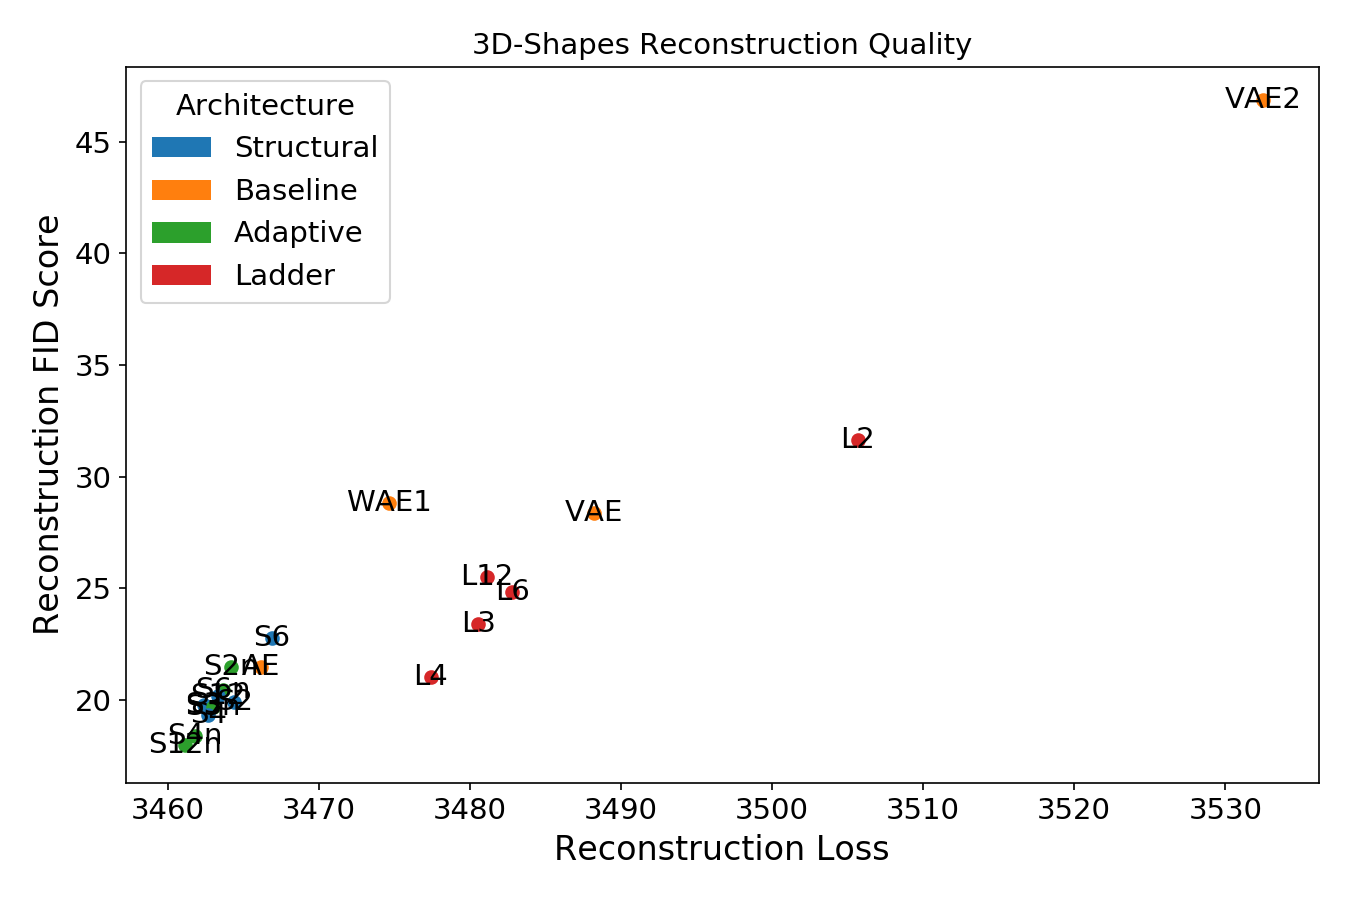

Figure 3ds_rec_quality saved as {'png', 'pdf'}


In [13]:
fig, ax = plt.subplots(figsize=info.fsize)

objs = []
texts = []
tps = set()
for r in runs:
    objs.append(plt.scatter(r.stats.rec_loss, r.stats.rec_fid, color=info.colors[r.group]))
    texts.append(plt.text(r.stats.rec_loss, r.stats.rec_fid, r.code, horizontalalignment='center',
      verticalalignment='center',))
    tps.add(r.group)

legend_elements = [Patch(facecolor=info.colors[name], label=info.group_names[name]) for name in tps]
plt.legend(handles=legend_elements, title='Architecture')
plt.xlabel('Reconstruction Loss')
plt.ylabel('Reconstruction FID Score')
plt.title(f'{info.title} Reconstruction Quality')
# plt.xlim(left=6370)
# plt.ylim(bottom=0)
plt.tight_layout()
# adjust_text(texts, #force_text=(0.1,0.1)
#             #force_text=(0.1,0.25),
#             add_objects=objs,
#            )
pass
util.save_figure(f'{dscode}_rec_quality', **save_figure_kwargs)

<IPython.core.display.Javascript object>


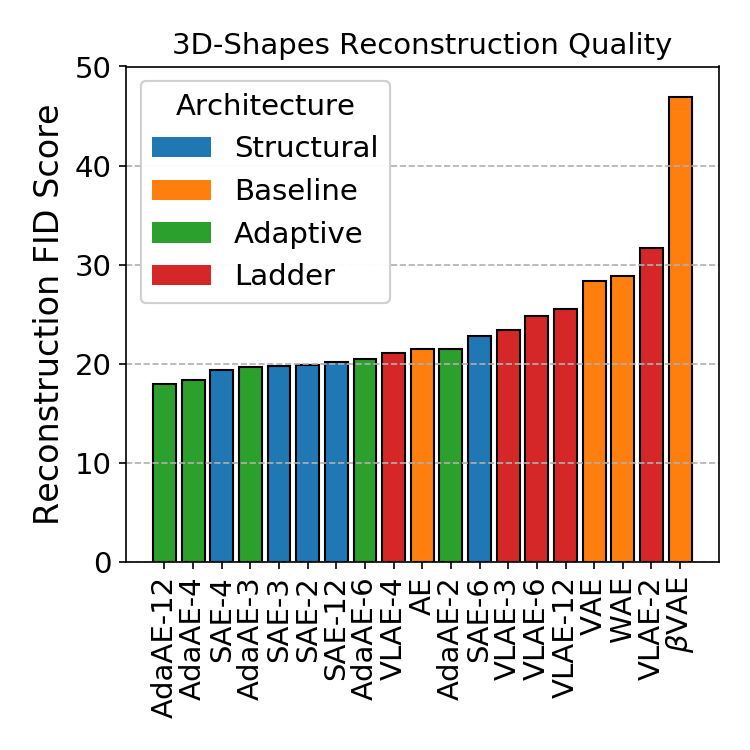

Figure 3ds_rec-fid saved as {'png', 'pdf'}


In [14]:
fig, ax = plt.subplots(figsize=(5,5))
# texts = []
# tps = set()
x = np.arange(len(title_order))

order = [x[1] for x in sorted((r.stats.rec_fid, r.ident) for r in runs)]
for i,t in enumerate(order):
    r = run_idents[t]
    s = r.stats.rec_fid
    c = info.colors[r.group]
    plt.bar(i, s, color=c, edgecolor='k', )#linewidth=2)
plt.xticks(x, [titles[t] for t in order], rotation='vertical')
#     plt.scatter(r.loss, r.fid, color=colors[r.type])
#     texts.append(plt.text(r.loss, r.fid, r.name))
#     tps.add(r.type)
#     plt.scatter(r.fid, r.loss, color=colors[r.type])
#     texts.append(plt.text(r.fid-(fidrg/10 if r.type == 'attn' else 0), r.loss, r.name))
# legend_elements = [Patch(facecolor=info.colors[name], label=info.tnames[name]) for name in set(typs)]
legend = plt.legend(handles=legend_elements, title='Architecture')
# plt.ylabel('Reconstruction Loss')
plt.ylabel('Reconstruction FID Score')
plt.title(f'{info.title} Reconstruction Quality')
# plt.yscale('log')
# s = [20,30,40,50,60,70, 80,90,100]
if dscode == 'celeb':
    plt.ylim(80,130)
elif dscode == '3ds':
    plt.ylim(0,50)
elif dscode == 'real':
    plt.ylim(0,70)
else:
    plt.ylim(0,100)
# plt.ylim(4550,4580)
# plt.yticks(s,map(str,s))
plt.grid(linestyle='--',axis='y')

# legend1 = plt.legend(legend_elements1, ['Hybrid', 'Prior'], loc=4, title='Sampling Method')
# ax.add_artist(legend1, )
ax.add_artist(legend)
plt.tight_layout()
util.save_figure(f'{dscode}_rec-fid', **save_figure_kwargs)
pass

In [20]:
scores = []
groups = []
typs = []
names = []

for r in runs:
    if 'hybrid_fid' in r.stats:
        scores.append(r.stats.hybrid_fid)
        groups.append(r.group)
        typs.append('hyb')
        names.append(r.title)
    if 'prior_fid' in r.stats:
        scores.append(r.stats.prior_fid)
        groups.append(r.group)
        typs.append('prior')
        names.append(r.title)
    if 'hyb_group_fid' in r.stats:
        scores.append(r.stats.hyb_group_fid)
        groups.append(r.group)
        typs.append('group')
        names.append(r.title)
        

scores = np.array(scores)
groups = np.array(groups)
typs = np.array(typs)
names = np.array(names)

order = np.argsort(scores)
scores = scores[order]
groups = groups[order]
typs = typs[order]
names = names[order]

eclrs = [('xx' if t == 'hyb' else ('**' if t=='group' else 'oo')) for t in typs]
clrs = [info.colors[g] for g in groups]

len(scores)

31

<IPython.core.display.Javascript object>


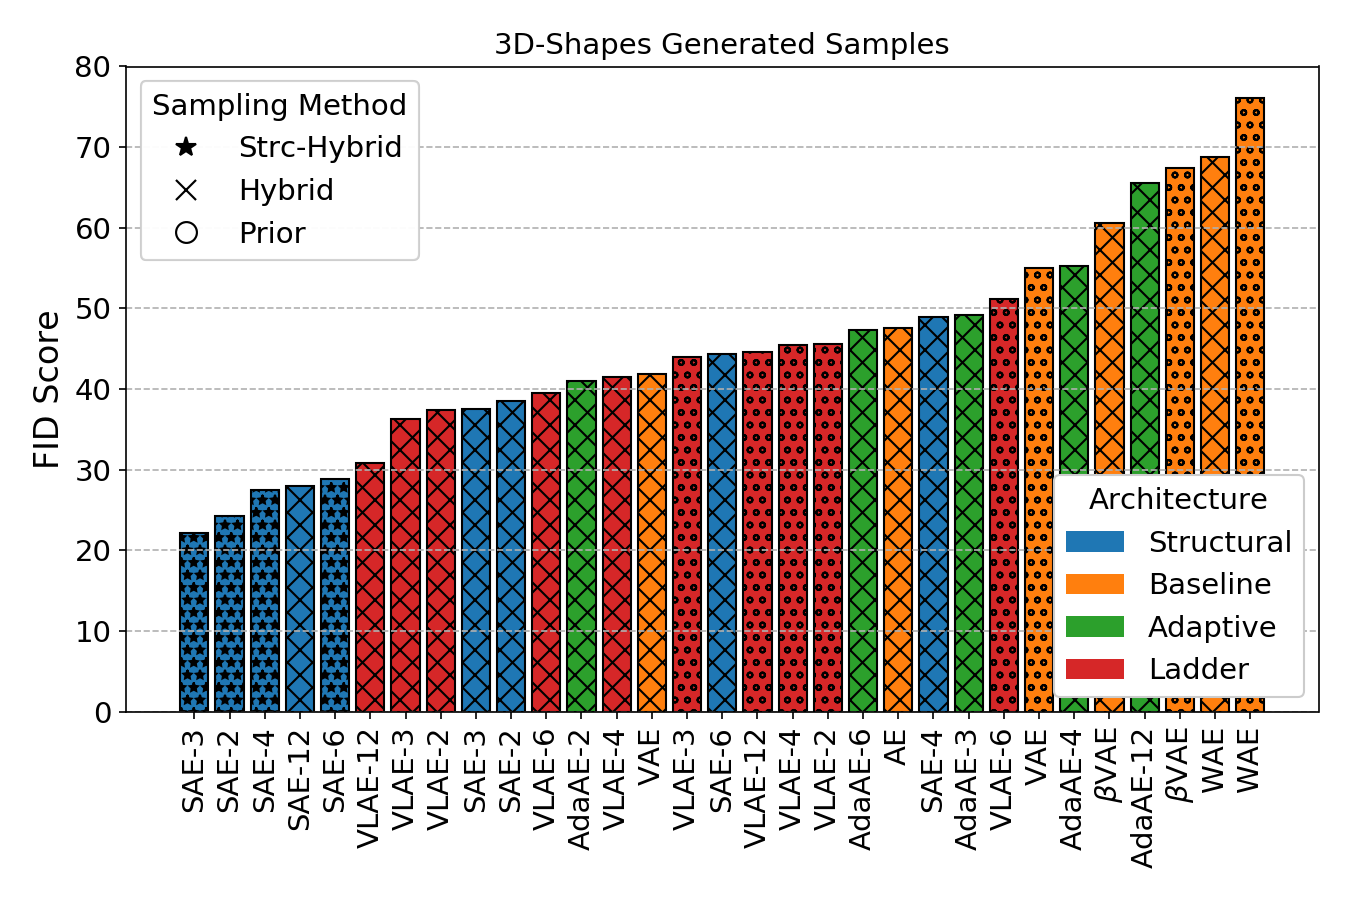

In [22]:
fig, ax = plt.subplots(figsize=info.fsize)
# texts = []
# tps = set()
x = np.arange(len(names))
for i,s,c,h in zip(x,scores,clrs,eclrs):
    plt.bar(i, s, color=c, edgecolor='k', hatch=h, )#linewidth=2)
plt.xticks(x, names, rotation='vertical')

legend_elements = [Patch(facecolor=info.colors[name], label=info.group_names[name]) for name in set(groups)]
# legend_elements1 = [Patch(facecolor='w', hatch='xxx', label='Hybrid'), Patch(facecolor='w', hatch='ooo', label='Prior')]

legend_elements1 = [mlines.Line2D([], [], color='k', marker='x', linestyle='None',
                          markersize=10, label='Hybrid'), 
                    mlines.Line2D([], [], color='k', marker='o', fillstyle='none', linestyle='None',
                          markersize=10, label='Prior')]
legend_titles = ['Hybrid', 'Prior']
if 'group' in typs:
    
    strctural = 'Strc-Hybrid'
    
    legend_elements1.insert(0, mlines.Line2D([], [], color='k', marker='*', linestyle='None',
                          markersize=10, label=strctural))
    legend_titles.insert(0, strctural)
legend = plt.legend(handles=legend_elements, loc=4, title='Architecture',  framealpha=1)
# plt.xlabel('Reconstruction Loss')
plt.ylabel('FID Score')
plt.title(f'{info.title} Generated Samples')
# plt.yscale('log')
if info.title == 'CelebA':
    plt.ylim(80,150)
elif dscode =='3ds':
    plt.ylim(0,80)
elif dscode == 'toy':
    plt.ylim(0,60)
elif dscode == 'sim':
    plt.ylim(0,100)
elif dscode == 'real':
    plt.ylim(0,90)
else:
    pass
# plt.yticks(s,map(str,s))
plt.grid(linestyle='--',axis='y')

legend1 = plt.legend(legend_elements1, legend_titles, loc=2, title='Sampling Method')
ax.add_artist(legend1, )
ax.add_artist(legend)
plt.tight_layout()
aden = 'grp' if include_group_hyb else ''
util.save_figure(f'{dscode}_gen{aden}', **save_figure_kwargs)
pass

In [17]:
run.results[info.cut].keys()

odict_keys(['device', 'original', 'batch', 'latent', 'reconstruction', 'rec_loss', 'loss', 'diffs', 'rec_fid_stats', 'rec_fid', 'hybrid_fid_stats', 'hybrid_fid'])

In [14]:
title_order

['AE S12',
 'AE S6',
 'AE S4',
 'AE S3',
 'AE S2',
 'VAE1 L12',
 'VAE1 L6',
 'VAE1 L4',
 'VAE1 L3',
 'VAE1 L2',
 'AE S12 nosplit',
 'AE S6 nosplit',
 'AE S4 nosplit',
 'AE S3 nosplit',
 'AE S2 nosplit',
 'AE',
 'VAE1',
 'VAE2',
 'WAE10']

In [13]:
run.stats.keys()

odict_keys(['rec_loss', 'rec_fid', 'hybrid_fid', 'IRS', 'DCI', 'SAP', 'MIG', 'ModExp', 'Response', 'Fairness'])

In [63]:
picks = ['Response', 'IRS', 'DCI', 'SAP', 'MIG', 'ModExp']


<IPython.core.display.Javascript object>


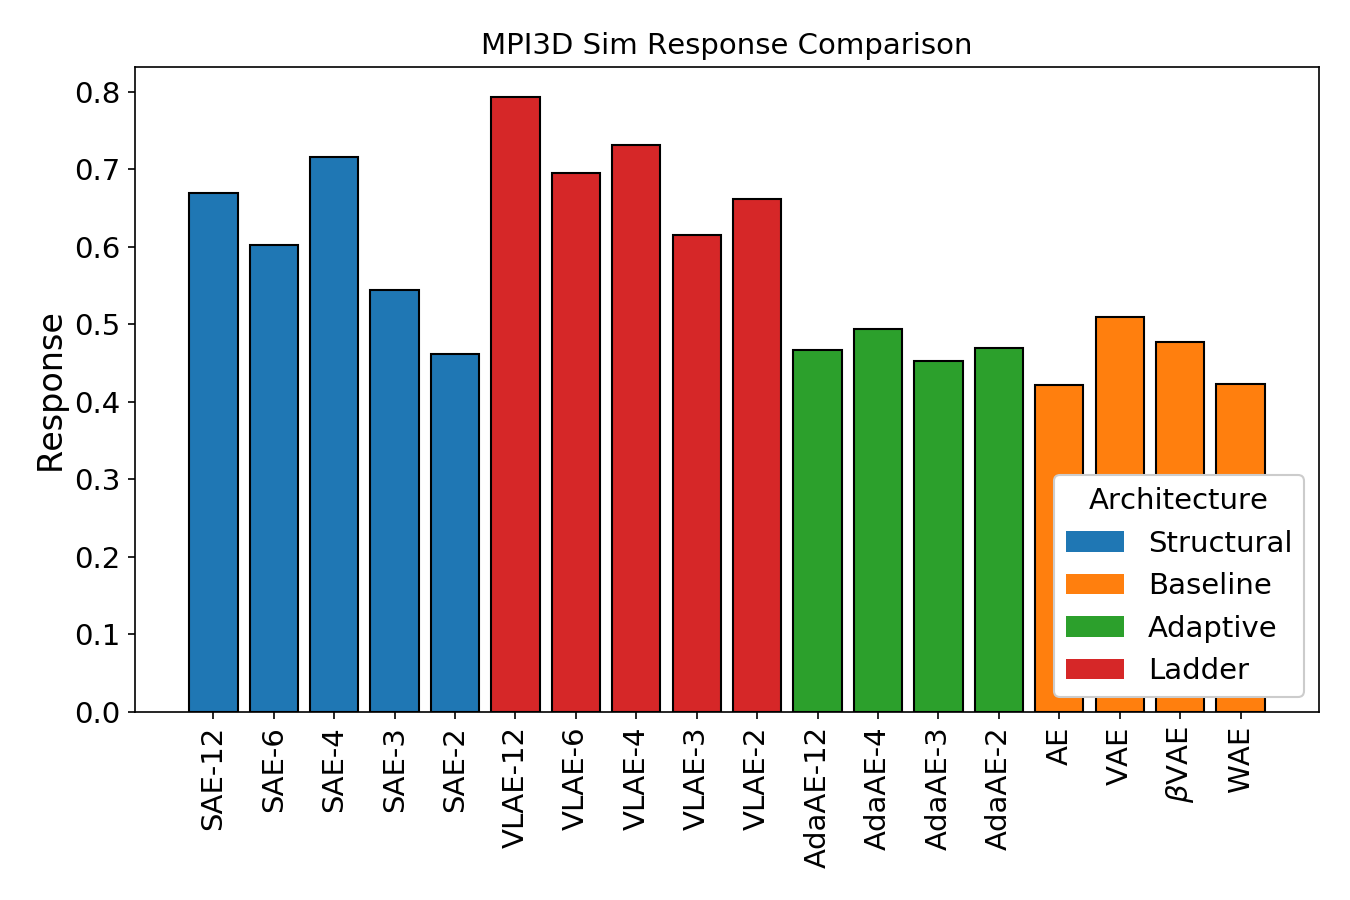

Figure sim_Response saved as {'pdf', 'png'}


<IPython.core.display.Javascript object>


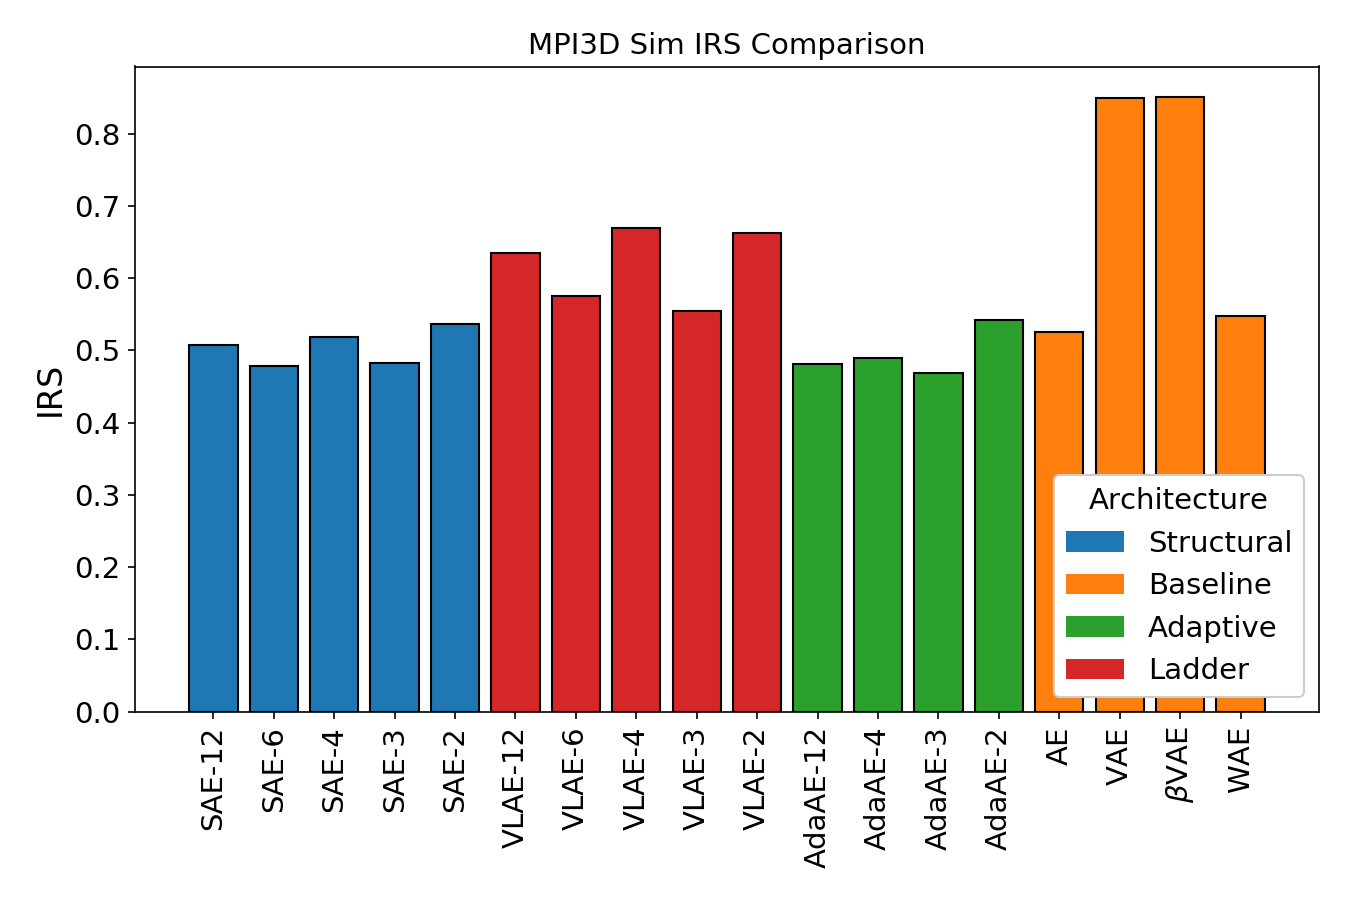

Figure sim_IRS saved as {'pdf', 'png'}


<IPython.core.display.Javascript object>


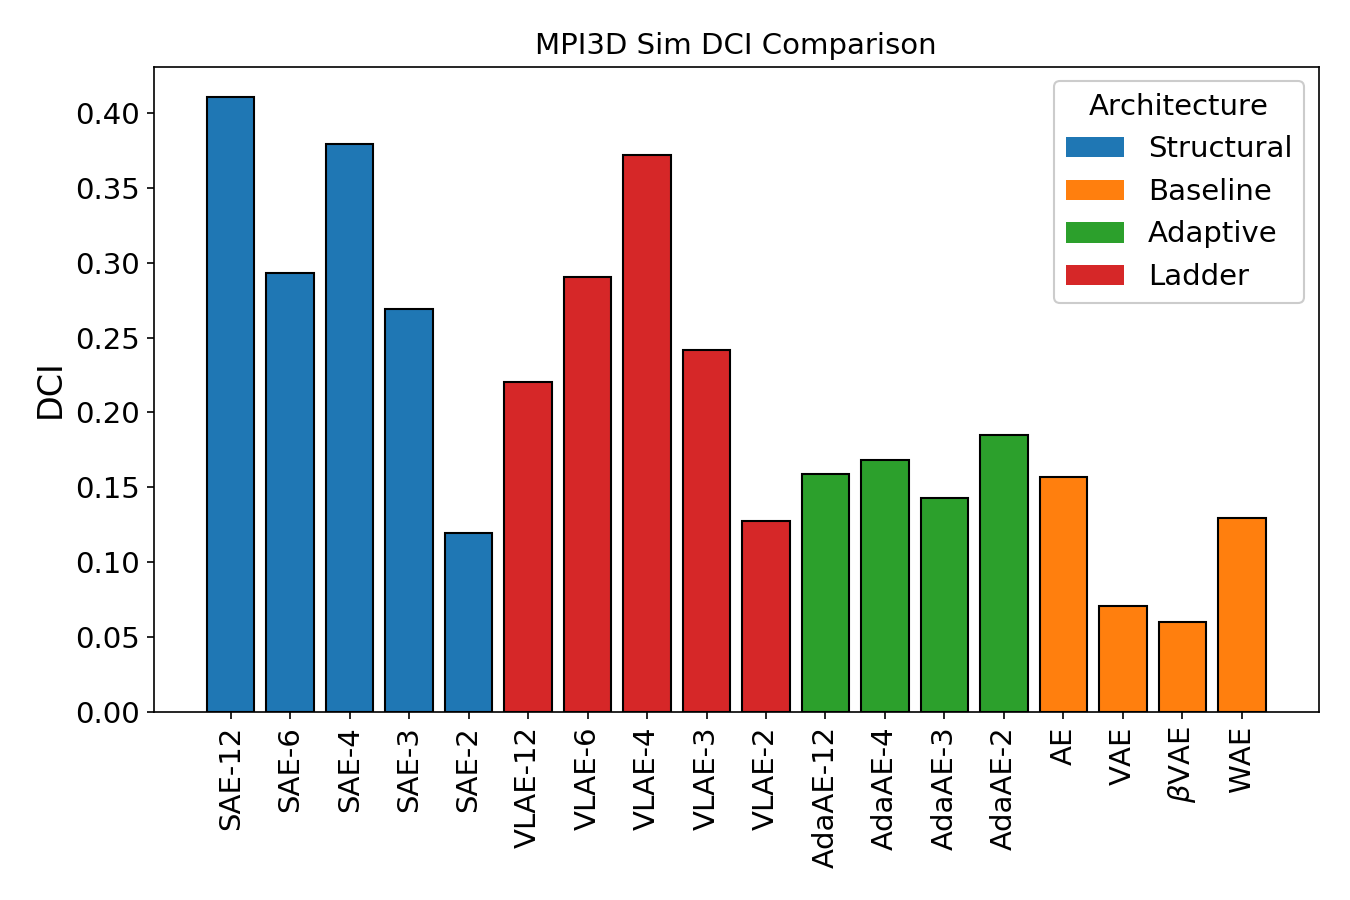

Figure sim_DCI saved as {'pdf', 'png'}


<IPython.core.display.Javascript object>


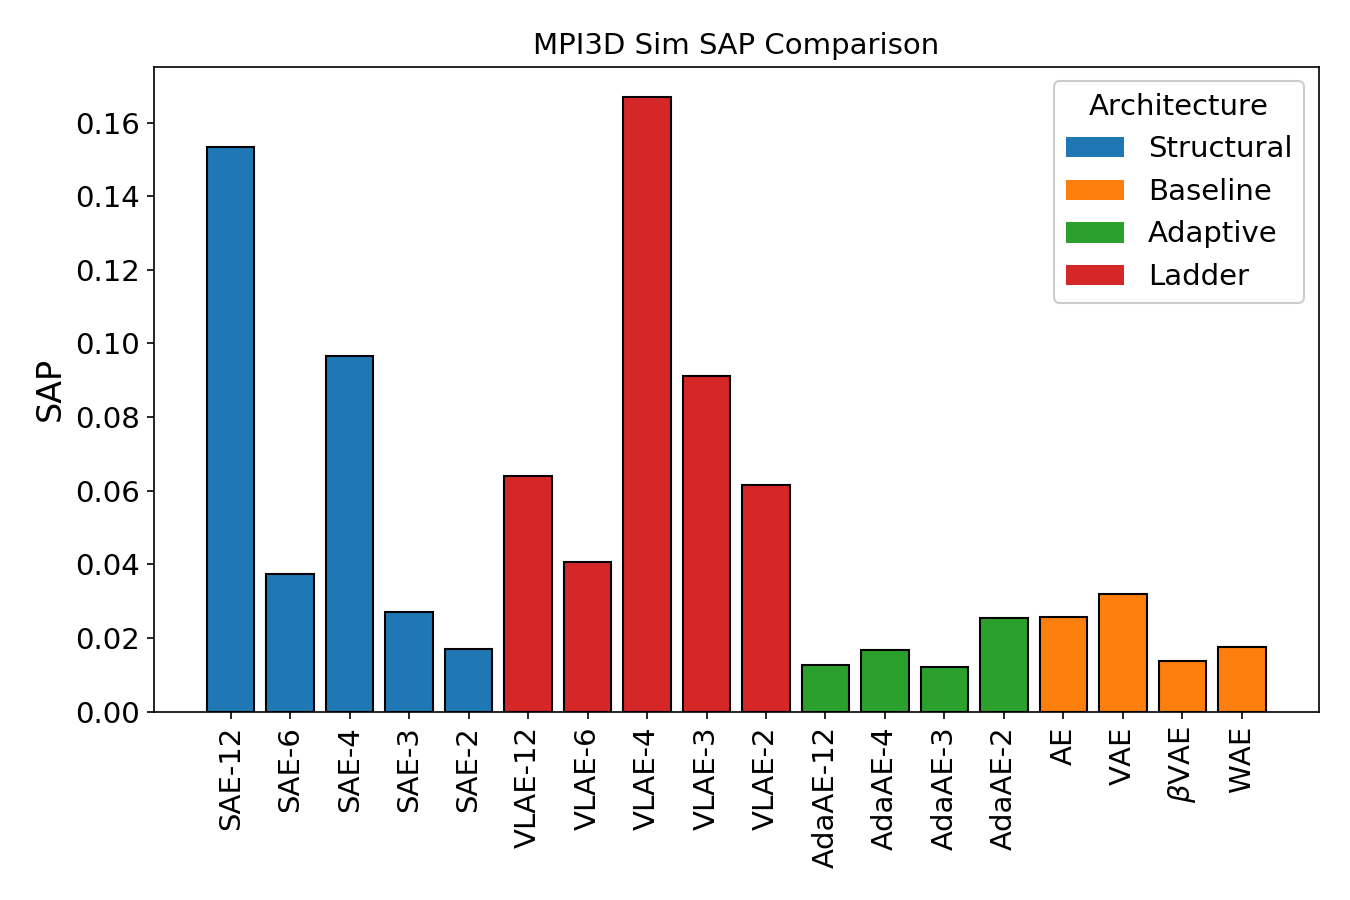

Figure sim_SAP saved as {'pdf', 'png'}


<IPython.core.display.Javascript object>


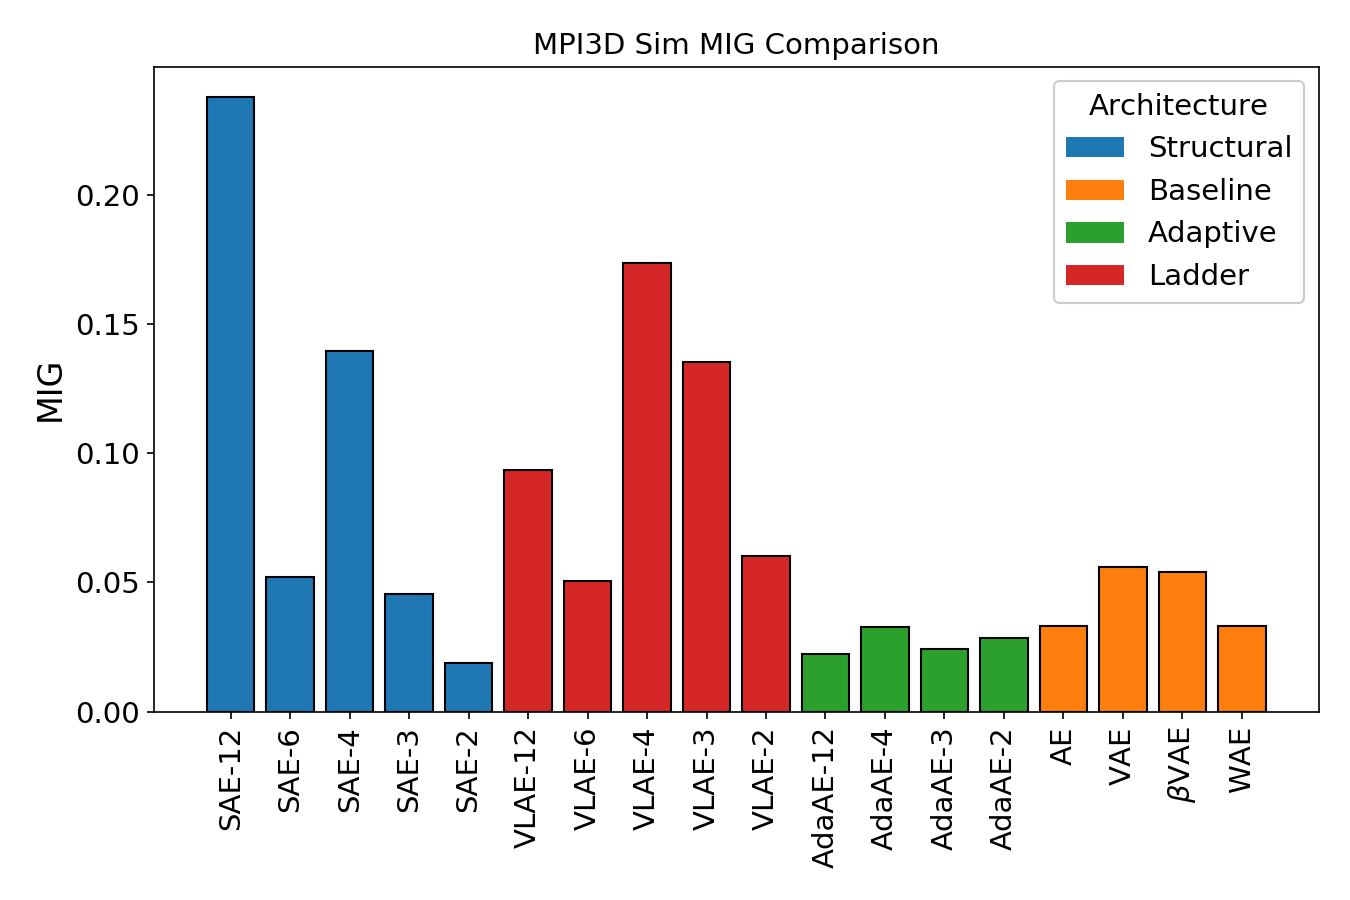

Figure sim_MIG saved as {'pdf', 'png'}


<IPython.core.display.Javascript object>


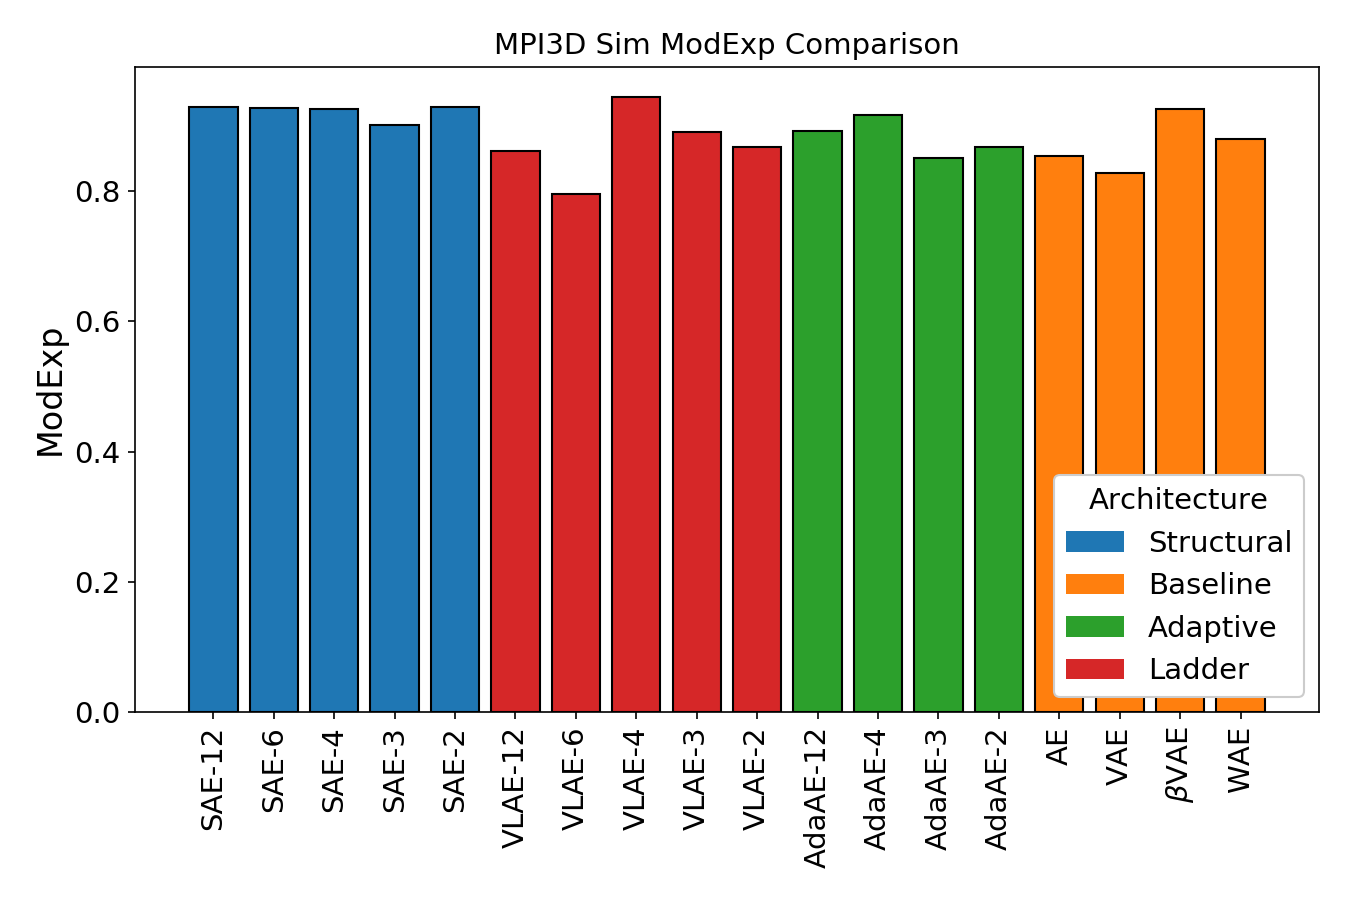

Figure sim_ModExp saved as {'pdf', 'png'}


In [64]:
for pick in picks:
    fig, ax = plt.subplots(figsize=info.fsize)
    x = np.arange(len(title_order))
    mu = 0
    mx = None
    for i,t in enumerate(title_order):
        r = run_idents[t]
        s = r.stats[pick]
        if mx is None or s > mx:
            mx = s
        mu += s
        c = info.colors[r.group]
        plt.bar(i, s, color=c, edgecolor='k', )
    plt.xticks(x, [titles[t] for t in title_order], rotation='vertical')
    mu /= len(title_order)
    
    legend_elements = [Patch(facecolor=info.colors[name], label=info.group_names[name]) for name in set(info.group_names)]
#     legend = plt.legend(handles=legend_elements, loc=4, title='Architecture',  framealpha=1)
    
    legend = plt.legend(handles=legend_elements, loc=(4 if 2*mx/3 < mu else 1), title='Architecture',  framealpha=1)

    # plt.xlabel('Reconstruction Loss')
    plt.ylabel(f'{pick}')
    plt.title(f'{info.title} {pick} Comparison')
    plt.tight_layout()
    util.save_figure(f'{dscode}_{pick}', **save_figure_kwargs)
    pass

In [82]:
run.data.keys()

odict_keys(['IRS', 'cov', 'SAP', 'DCI', 'Response', 'FactorResponse'])

In [161]:
mat_name = 'FactorResponse'
mat_name = 'Response'
# mat_name = 'DCI'

In [162]:
allRs = {r.ident:(r.data[mat_name].min(1)[0].max(-1)[0] if mat_name == 'FactorResponse' else (r.data[mat_name].T if mat_name == 'DCI' else r.data[mat_name])) for r in runs}
allRs.keys()

dict_keys(['AE', 'VAE1', 'VAE2', 'WAE10', 'AE S2', 'AE S2 nosplit', 'AE S3', 'AE S3 nosplit', 'AE S4', 'AE S4 nosplit', 'AE S6', 'AE S6 nosplit', 'AE S12', 'AE S12 nosplit', 'VAE1 L2', 'VAE1 L3', 'VAE1 L4', 'VAE1 L6', 'VAE1 L12'])

In [163]:
factor_order = ['object_color', 'object_shape', 'object_size', 'camera_height', 'background_color',
		                     'horizonal_axis', 'vertical_axis'] if dscode in {'toy', 'sim',  'real'} else ['floor_hue', 'wall_hue', 'object_hue', 'scale', 'shape', 'orientation']

In [164]:
H,W = util.calc_tiling(20)
H,W

(4, 5)

<IPython.core.display.Javascript object>


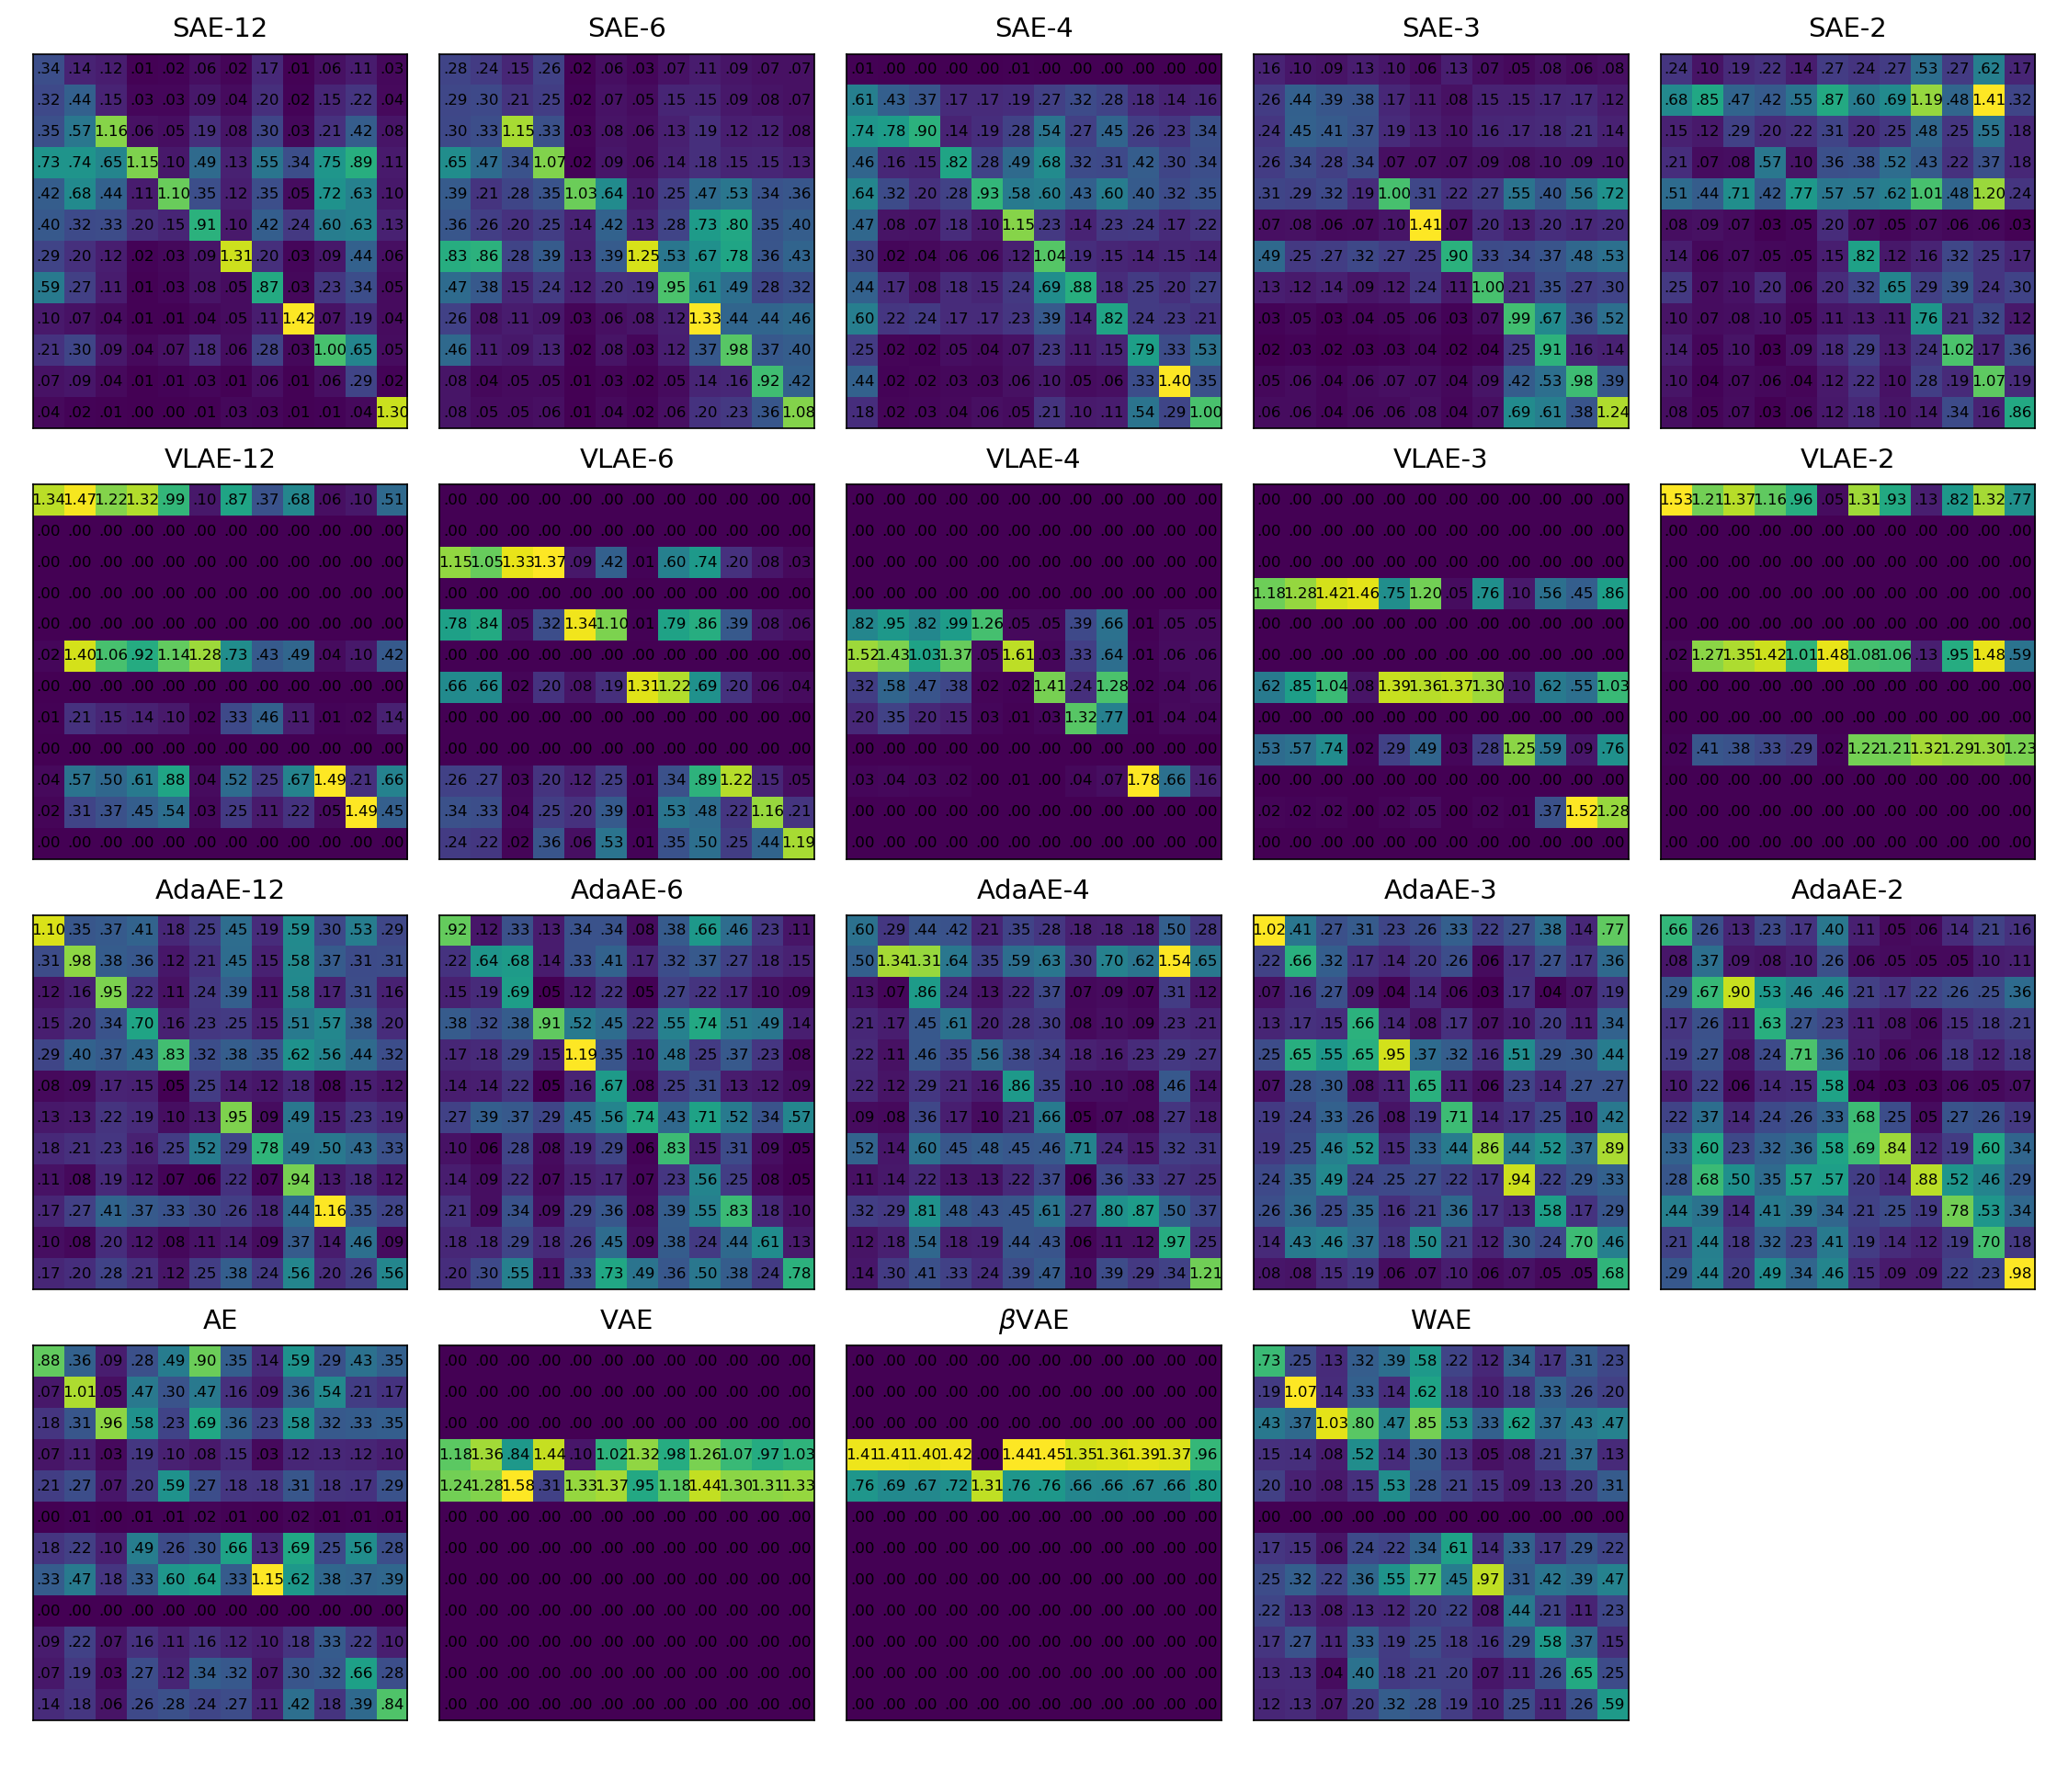

Figure toy_Response_matrices saved as {'pdf', 'png'}


In [165]:
fg, axes = plt.subplots(H,W, figsize=(15,13))
axes = axes.reshape(-1)

for ax, title in zip(axes, title_order):
    plt.sca(ax)
    
    Rs = allRs[title]
    
#     util.plot_mat(Rs.mean(0), val_fmt=1, figax=(fg, ax));
    util.plot_mat(Rs, val_fmt=lambda x: f'{x:.2f}'.lstrip('0'), figax=(fg, ax), text_kwargs={'size':8});
    plt.xticks([])
    plt.yticks([])
    plt.title(run_idents[title].title, pad=-1)

    
for i in range(len(allRs), 20):
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.15, wspace=0.02, bottom=0.04, top=0.97, left=0.01, right=0.99)
util.save_figure(f'{dscode}_{mat_name}_matrices', **save_figure_kwargs)